In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class Policy(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, output_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return F.softmax(self.fc2(F.relu(self.fc1(x))), dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [5]:
class Policy_baseline(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Policy_baseline, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to("cpu")
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(torch.tensor(action))

In [6]:
import gymnasium as gym
env = gym.make('CartPole-v1')

In [7]:
def reinforce_without_baseline(policy, optimizer, n_episodes=5000, max_t=1000, gamma=0.99, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state, _ = env.reset(seed=np.random.randint(0, 10))
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, truncated, info = env.step(action)
            rewards.append(reward)
            if done or truncated:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        G = sum([a*b for a, b in zip(discounts, rewards)])

        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * G)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            torch.save(policy.state_dict(), 'checkpoint_without_baseline.pth')
            print('Episode {}\tAverage Score: {:.2f}'.format(
                e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 490:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                e, np.mean(scores_deque)))
            break
    return scores

In [8]:

class Value_function(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Value_function, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
def reinforce_with_baseline(policy, optimizer, value_optimizer, value_loss, state_value_function, n_episodes=5000, max_t=1000, gamma=0.99, print_every=100, tau=0.005, min_episode=800):
    scores = []
    target_value_function = Value_function(
        input_size=4, hidden_size=32, output_size=1)

    for episode in range(1, n_episodes):
        state = env.reset(seed=np.random.randint(0, 10))
        scores_deque = deque(maxlen=500)
        state = state[0]
        states = []
        states.append(state)
        saved_log_probs = []
        G = 0
        G_non_discounted = 0
        I = 1
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            next_state, reward, done, truncated, info = env.step(action)
            states.append(next_state)
            value_optimizer.zero_grad()
            for target_param, param in zip(target_value_function.parameters(), state_value_function.parameters()):
                target_param.data.copy_(
                    tau * param.data + (1 - tau) * target_param.data)

            loss = value_loss(state_value_function(torch.tensor(state, dtype=torch.float)), reward +
                              gamma*target_value_function(torch.tensor(next_state, dtype=torch.float)))

            loss.backward()
            value_optimizer.step()
            G += reward*I
            G_non_discounted += reward
            I = I*gamma
            if done or truncated:
                break
            state = next_state
        scores.append(G_non_discounted)
        scores_deque.append(G_non_discounted)
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob *
                               (G-state_value_function(torch.tensor(states, dtype=torch.float))))

        policy_loss = torch.cat(policy_loss).sum()
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(
                episode, np.mean(scores_deque)))

        if np.mean(scores_deque) >= 490 and episode >= min_episode:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                episode, np.mean(scores_deque)))
            break

    return scores

In [ ]:
policy = Policy()
policy_optimizer = optim.Adam(policy.parameters(), lr=0.001)
scores = reinforce_without_baseline(policy, policy_optimizer, gamma=0.99)

In [ ]:
policy_with_baseline = Policy()
policy_optimizer = optim.Adam(policy.parameters(), lr=1e-3)
value_function = Value_function()
value_loss = nn.MSELoss()
value_optimizer = optim.Adam(value_function.parameters(), lr=1e-3)
scores = reinforce_with_baseline(
    policy, policy_optimizer, value_optimizer, value_loss, value_function, gamma=0.99)

# Training for five random seeds CartPole without baseline

In [19]:
n_seeds = 5
final_scores_no_baseline = []

for i in range(n_seeds):
    policy = Policy()
    policy_optimizer = optim.Adam(policy.parameters(), lr=0.001)
    scores = reinforce_without_baseline(
        policy, policy_optimizer, gamma=0.99, n_episodes=10000)
    final_scores_no_baseline.append(scores)

Episode 100	Average Score: 20.11
Episode 200	Average Score: 18.71
Episode 300	Average Score: 23.02
Episode 400	Average Score: 22.45
Episode 500	Average Score: 28.32
Episode 600	Average Score: 28.65
Episode 700	Average Score: 30.60
Episode 800	Average Score: 35.20
Episode 900	Average Score: 38.11
Episode 1000	Average Score: 40.64
Episode 1100	Average Score: 40.94
Episode 1200	Average Score: 45.14
Episode 1300	Average Score: 45.17
Episode 1400	Average Score: 43.21
Episode 1500	Average Score: 50.86
Episode 1600	Average Score: 49.56
Episode 1700	Average Score: 57.11
Episode 1800	Average Score: 48.49
Episode 1900	Average Score: 52.21
Episode 2000	Average Score: 60.07
Episode 2100	Average Score: 64.31
Episode 2200	Average Score: 76.80
Episode 2300	Average Score: 88.19
Episode 2400	Average Score: 91.35
Episode 2500	Average Score: 82.82
Episode 2600	Average Score: 89.45
Episode 2700	Average Score: 97.12
Episode 2800	Average Score: 116.14
Episode 2900	Average Score: 118.19
Episode 3000	Average 

In [20]:
import pickle
with open('final_scores_no_baseline_cartpole_v3', 'wb') as f:
    pickle.dump(final_scores_no_baseline, f)

In [26]:
import numpy as np
import pickle
with open('final_scores_no_baseline_cartpole_v3', 'rb') as f:
    final_scores_no_baseline = pickle.load(f)

print(final_scores_no_baseline)

[[11.0, 38.0, 41.0, 16.0, 41.0, 18.0, 16.0, 10.0, 18.0, 24.0, 11.0, 19.0, 28.0, 13.0, 34.0, 21.0, 40.0, 13.0, 22.0, 19.0, 18.0, 42.0, 21.0, 20.0, 15.0, 17.0, 19.0, 16.0, 14.0, 10.0, 14.0, 42.0, 14.0, 14.0, 33.0, 12.0, 12.0, 13.0, 15.0, 11.0, 18.0, 17.0, 20.0, 14.0, 12.0, 14.0, 25.0, 63.0, 26.0, 20.0, 14.0, 13.0, 26.0, 12.0, 14.0, 47.0, 14.0, 12.0, 20.0, 28.0, 16.0, 17.0, 18.0, 18.0, 13.0, 16.0, 19.0, 16.0, 20.0, 16.0, 72.0, 13.0, 20.0, 16.0, 9.0, 27.0, 21.0, 37.0, 21.0, 20.0, 12.0, 17.0, 10.0, 13.0, 12.0, 14.0, 36.0, 17.0, 32.0, 11.0, 12.0, 16.0, 17.0, 13.0, 14.0, 11.0, 14.0, 13.0, 38.0, 10.0, 11.0, 10.0, 16.0, 10.0, 18.0, 23.0, 11.0, 12.0, 21.0, 24.0, 16.0, 11.0, 16.0, 25.0, 33.0, 17.0, 15.0, 20.0, 36.0, 24.0, 37.0, 31.0, 9.0, 27.0, 15.0, 14.0, 20.0, 29.0, 10.0, 13.0, 17.0, 12.0, 12.0, 9.0, 15.0, 10.0, 10.0, 22.0, 9.0, 14.0, 21.0, 19.0, 14.0, 21.0, 16.0, 36.0, 22.0, 21.0, 16.0, 18.0, 24.0, 41.0, 13.0, 16.0, 10.0, 11.0, 16.0, 11.0, 16.0, 34.0, 13.0, 18.0, 17.0, 19.0, 18.0, 42.0, 14.0, 

In [27]:
min_length_no_baseline = 5000
for row in final_scores_no_baseline:
    if min_length_no_baseline > len(row):
        min_length_no_baseline = len(row)

Text(0.5, 1.0, 'REINFORCE Learning Curve for No Baseline Cartpole ')

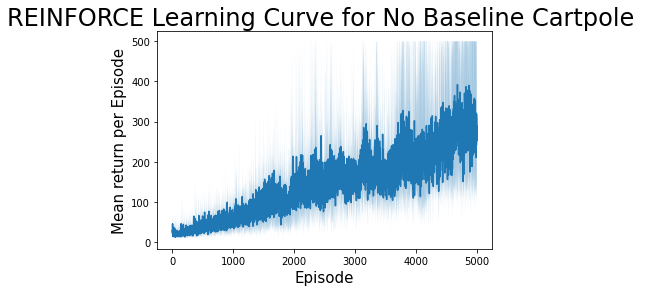

In [28]:
import matplotlib.pyplot as plt
clipped_data = [row[:min_length_no_baseline]
                for row in final_scores_no_baseline]
clipped_array = np.array(clipped_data)
means = np.mean(clipped_array, axis=0)
mins = np.min(clipped_array, axis=0)
maxs = np.max(clipped_array, axis=0)
ks = np.arange(1, min_length_no_baseline+1)
plt.fill_between(ks, mins, maxs, alpha=0.4)
plt.plot(ks, means)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Mean return per Episode', fontsize=15)

plt.title("REINFORCE Learning Curve for No Baseline Cartpole ", fontsize=24)

# Training for five random seeds CartPole with baseline

In [31]:
n_seeds = 5
final_scores_baseline = []

for i in range(n_seeds):
    policy = Policy_baseline(input_size=4, hidden_size=32, output_size=2)
    policy_optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    value_function = Value_function(
        input_size=4, hidden_size=32, output_size=1)
    value_loss = nn.MSELoss()
    value_optimizer = optim.Adam(value_function.parameters(), lr=1e-3)
    scores = reinforce_with_baseline(
        policy, policy_optimizer, value_optimizer, value_loss, value_function, gamma=0.99, max_t=1000, n_episodes=5000)
    final_scores_baseline.append(scores)

/home/keerthivasan/miniconda3/envs/YOLOP_lane/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 100	Average Score: 16.00
Episode 200	Average Score: 17.00
Episode 300	Average Score: 107.00
Episode 400	Average Score: 50.00
Episode 500	Average Score: 61.00
Episode 600	Average Score: 115.00
Episode 700	Average Score: 117.00
Episode 800	Average Score: 127.00
Episode 900	Average Score: 177.00
Environment solved in 919 episodes!	Average Score: 500.00
Episode 100	Average Score: 18.00
Episode 200	Average Score: 13.00
Episode 300	Average Score: 44.00
Episode 400	Average Score: 128.00
Episode 500	Average Score: 500.00
Episode 600	Average Score: 500.00
Episode 700	Average Score: 423.00
Episode 800	Average Score: 500.00
Environment solved in 800 episodes!	Average Score: 500.00
Episode 100	Average Score: 34.00
Episode 200	Average Score: 9.00
Episode 300	Average Score: 36.00
Episode 400	Average Score: 33.00
Episode 500	Average Score: 75.00
Episode 600	Average Score: 137.00
Episode 700	Average Score: 131.00
Episode 800	Average Score: 500.00
Environment solved in 800 episodes!	Average Sco

In [32]:
import pickle
with open('final_scores_baseline_cartpole_v2', 'wb') as f:
    pickle.dump(final_scores_baseline, f)

In [43]:
import numpy as np
import pickle
with open('final_scores_baseline_cartpole_v2', 'rb') as f:
    final_scores_baseline = pickle.load(f)

print(final_scores_baseline)

[[40.0, 22.0, 21.0, 28.0, 32.0, 21.0, 21.0, 16.0, 11.0, 24.0, 35.0, 16.0, 21.0, 81.0, 13.0, 27.0, 23.0, 12.0, 17.0, 12.0, 20.0, 44.0, 15.0, 16.0, 14.0, 41.0, 10.0, 20.0, 24.0, 36.0, 22.0, 12.0, 38.0, 12.0, 17.0, 36.0, 16.0, 19.0, 13.0, 20.0, 20.0, 13.0, 13.0, 24.0, 20.0, 18.0, 15.0, 16.0, 11.0, 12.0, 15.0, 13.0, 13.0, 24.0, 14.0, 43.0, 11.0, 8.0, 9.0, 16.0, 15.0, 35.0, 23.0, 11.0, 15.0, 18.0, 59.0, 19.0, 31.0, 41.0, 37.0, 24.0, 20.0, 17.0, 14.0, 11.0, 13.0, 16.0, 21.0, 16.0, 57.0, 31.0, 23.0, 26.0, 20.0, 26.0, 19.0, 46.0, 27.0, 30.0, 20.0, 16.0, 47.0, 33.0, 21.0, 49.0, 36.0, 14.0, 31.0, 16.0, 44.0, 27.0, 38.0, 24.0, 28.0, 28.0, 28.0, 24.0, 19.0, 15.0, 18.0, 19.0, 12.0, 15.0, 16.0, 37.0, 23.0, 16.0, 12.0, 13.0, 19.0, 18.0, 21.0, 28.0, 13.0, 28.0, 77.0, 57.0, 25.0, 46.0, 19.0, 16.0, 14.0, 36.0, 12.0, 18.0, 39.0, 24.0, 11.0, 19.0, 23.0, 50.0, 13.0, 44.0, 38.0, 13.0, 18.0, 26.0, 71.0, 11.0, 15.0, 15.0, 21.0, 18.0, 22.0, 41.0, 22.0, 23.0, 28.0, 16.0, 14.0, 23.0, 22.0, 14.0, 55.0, 16.0, 23.0

In [44]:
min_length_baseline = 5000
for row in final_scores_baseline:
    if min_length_baseline > len(row):
        min_length_baseline = len(row)

In [35]:
# print(final_scores_baseline[::min_length])
# # print(final_scores_baseline[])

[[40.0, 22.0, 21.0, 28.0, 32.0, 21.0, 21.0, 16.0, 11.0, 24.0, 35.0, 16.0, 21.0, 81.0, 13.0, 27.0, 23.0, 12.0, 17.0, 12.0, 20.0, 44.0, 15.0, 16.0, 14.0, 41.0, 10.0, 20.0, 24.0, 36.0, 22.0, 12.0, 38.0, 12.0, 17.0, 36.0, 16.0, 19.0, 13.0, 20.0, 20.0, 13.0, 13.0, 24.0, 20.0, 18.0, 15.0, 16.0, 11.0, 12.0, 15.0, 13.0, 13.0, 24.0, 14.0, 43.0, 11.0, 8.0, 9.0, 16.0, 15.0, 35.0, 23.0, 11.0, 15.0, 18.0, 59.0, 19.0, 31.0, 41.0, 37.0, 24.0, 20.0, 17.0, 14.0, 11.0, 13.0, 16.0, 21.0, 16.0, 57.0, 31.0, 23.0, 26.0, 20.0, 26.0, 19.0, 46.0, 27.0, 30.0, 20.0, 16.0, 47.0, 33.0, 21.0, 49.0, 36.0, 14.0, 31.0, 16.0, 44.0, 27.0, 38.0, 24.0, 28.0, 28.0, 28.0, 24.0, 19.0, 15.0, 18.0, 19.0, 12.0, 15.0, 16.0, 37.0, 23.0, 16.0, 12.0, 13.0, 19.0, 18.0, 21.0, 28.0, 13.0, 28.0, 77.0, 57.0, 25.0, 46.0, 19.0, 16.0, 14.0, 36.0, 12.0, 18.0, 39.0, 24.0, 11.0, 19.0, 23.0, 50.0, 13.0, 44.0, 38.0, 13.0, 18.0, 26.0, 71.0, 11.0, 15.0, 15.0, 21.0, 18.0, 22.0, 41.0, 22.0, 23.0, 28.0, 16.0, 14.0, 23.0, 22.0, 14.0, 55.0, 16.0, 23.0

Text(0.5, 1.0, 'REINFORCE Learning Curve')

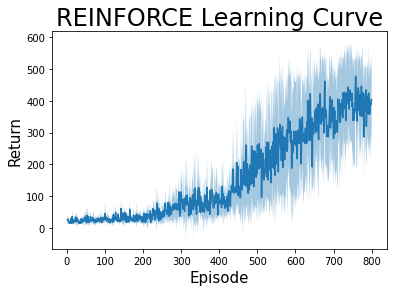

In [47]:
import matplotlib.pyplot as plt
clipped_data = [row[:min_length_baseline] for row in final_scores_baseline]
clipped_array = np.array(clipped_data)
means = np.mean(clipped_array, axis=0)
mins = means-np.std(clipped_array, axis=0)
maxs = means+np.std(clipped_array, axis=0)
ks = np.arange(1, min_length_baseline+1)
plt.fill_between(ks, mins, maxs, alpha=0.4)
plt.plot(ks, means)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Return', fontsize=15)

plt.title("REINFORCE Learning Curve", fontsize=24)

# Training for one iteration to visualize with Baseline Cartpole

In [22]:
policy_baseline = Policy_baseline(input_size=4, hidden_size=32, output_size=2)
policy_optimizer = optim.Adam(policy_baseline.parameters(), lr=1e-3)
value_function = Value_function(
    input_size=4, hidden_size=32, output_size=1)
value_loss = nn.MSELoss()
value_optimizer = optim.Adam(value_function.parameters(), lr=1e-3)
scores = reinforce_with_baseline(
    policy_baseline, policy_optimizer, value_optimizer, value_loss, value_function, gamma=0.99, max_t=1000, n_episodes=5000, min_episode=1000)

/home/keerthivasan/miniconda3/envs/YOLOP_lane/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 100	Average Score: 19.00
Episode 200	Average Score: 50.00
Episode 300	Average Score: 85.00
Episode 400	Average Score: 114.00
Episode 500	Average Score: 50.00
Episode 600	Average Score: 224.00
Episode 700	Average Score: 251.00
Episode 800	Average Score: 500.00
Episode 900	Average Score: 500.00
Episode 1000	Average Score: 500.00
Environment solved in 1000 episodes!	Average Score: 500.00


/home/keerthivasan/miniconda3/envs/YOLOP_lane/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


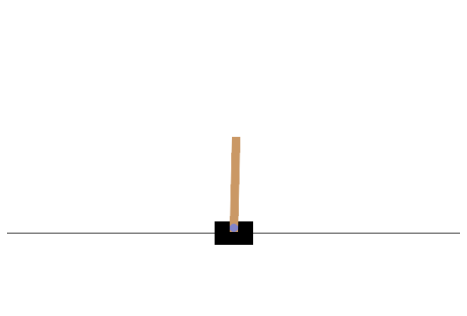

In [23]:
from matplotlib import animation
import matplotlib.pyplot as plt
env = gym.make('CartPole-v1', render_mode="rgb_array")
state, _ = env.reset()
frames = []
path = './'
filename = 'cartpole_baseline.gif'
for t in range(1000):
    frames.append(env.render())
    action, _ = policy_baseline.act(state)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state
    if done or truncated:
        print(t)
        break
env.close()
plt.figure(figsize=(frames[0].shape[1] / 72.0,
           frames[0].shape[0] / 72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')


def animate(i):
    patch.set_data(frames[i])


anim = animation.FuncAnimation(
    plt.gcf(), animate, frames=len(frames), interval=50)
anim.save(path + filename, writer='imagemagick', fps=60)

# Training for one iteration to visualize without Baseline Cartpole

In [24]:
policy_no_baseline = Policy()
policy_optimizer = optim.Adam(policy_no_baseline.parameters(), lr=0.001)
scores = reinforce_without_baseline(
    policy_no_baseline, policy_optimizer, gamma=0.99, n_episodes=10000)

Episode 100	Average Score: 24.05
Episode 200	Average Score: 26.94
Episode 300	Average Score: 34.62
Episode 400	Average Score: 38.16
Episode 500	Average Score: 43.72
Episode 600	Average Score: 47.05
Episode 700	Average Score: 53.85
Episode 800	Average Score: 50.35
Episode 900	Average Score: 54.78
Episode 1000	Average Score: 61.71
Episode 1100	Average Score: 64.42
Episode 1200	Average Score: 58.93
Episode 1300	Average Score: 59.71
Episode 1400	Average Score: 64.32
Episode 1500	Average Score: 66.82
Episode 1600	Average Score: 59.29
Episode 1700	Average Score: 77.39
Episode 1800	Average Score: 85.37
Episode 1900	Average Score: 77.26
Episode 2000	Average Score: 83.62
Episode 2100	Average Score: 79.82
Episode 2200	Average Score: 83.16
Episode 2300	Average Score: 102.76
Episode 2400	Average Score: 107.65
Episode 2500	Average Score: 88.65
Episode 2600	Average Score: 95.58
Episode 2700	Average Score: 95.89
Episode 2800	Average Score: 97.42
Episode 2900	Average Score: 100.38
Episode 3000	Average

/home/keerthivasan/miniconda3/envs/YOLOP_lane/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


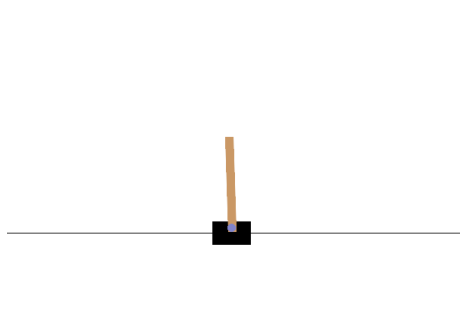

In [25]:
from matplotlib import animation
import matplotlib.pyplot as plt
env = gym.make('CartPole-v1', render_mode="rgb_array")
state, _ = env.reset()
frames = []
path = './'
filename = 'cartpole.gif'
for t in range(1000):
    frames.append(env.render())
    action, _ = policy_baseline.act(state)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state
    if done or truncated:
        break
env.close()
plt.figure(figsize=(frames[0].shape[1] / 72.0,
           frames[0].shape[0] / 72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')


def animate(i):
    patch.set_data(frames[i])


anim = animation.FuncAnimation(
    plt.gcf(), animate, frames=len(frames), interval=50)
anim.save(path + filename, writer='imagemagick', fps=60)

# Final Reward Plot

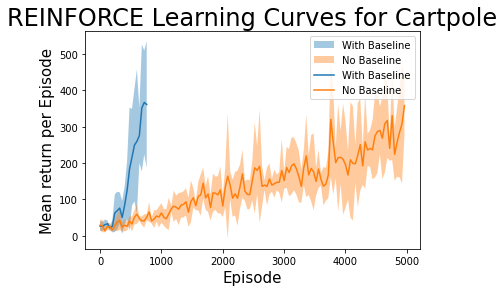

In [50]:
import matplotlib.pyplot as plt
import numpy as np


clipped_data_baseline = [row[:min_length_baseline]
                         for row in final_scores_baseline]
clipped_array_baseline = np.array(clipped_data_baseline)

clipped_data_no_baseline = [row[:min_length_no_baseline]
                            for row in final_scores_no_baseline]
clipped_array_no_baseline = np.array(clipped_data_no_baseline)

means_baseline = np.mean(clipped_array_baseline, axis=0)[::40]
mins_baseline = means_baseline-np.std(clipped_array_baseline, axis=0)[::40]
maxs_baseline = means_baseline+np.std(clipped_array_baseline, axis=0)[::40]

means_no_baseline = np.mean(clipped_array_no_baseline, axis=0)[::40]
mins_no_baseline = means_no_baseline - \
    np.std(clipped_array_no_baseline, axis=0)[::40]
maxs_no_baseline = means_no_baseline + \
    np.std(clipped_array_no_baseline, axis=0)[::40]

ks_baseline = np.arange(1, min_length_baseline+1)[::40]
ks_no_baseline = np.arange(1, min_length_no_baseline+1)[::40]

plt.fill_between(ks_baseline, mins_baseline, maxs_baseline,
                 alpha=0.4, label='With Baseline')
plt.fill_between(ks_no_baseline, mins_no_baseline,
                 maxs_no_baseline, alpha=0.4, label='No Baseline')


plt.plot(ks_baseline, means_baseline, label='With Baseline')
plt.plot(ks_no_baseline, means_no_baseline, label='No Baseline')


plt.xlabel('Episode', fontsize=15)
plt.ylabel('Mean return per Episode', fontsize=15)
plt.title("REINFORCE Learning Curves for Cartpole", fontsize=24)

plt.legend()

plt.show()